# Import des librairies

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta

from sklearn import preprocessing
from sklearn import cluster, metrics
from scipy.spatial.distance import cdist
from sklearn import decomposition, manifold
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier 

In [2]:
data=pd.read_csv('Data_final.csv',index_col=0)

In [3]:
data.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id', 'price',
       'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'review_id', 'review_score',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'Durée_livraison', 'Prix_produit',
       'Prix_Livraison', 'Montant_achat', 'Montant_achat_LOG',
       'product_volume', 'frequence_commande', 'date_achat_max', 'Récence',
       'Somme_depensee', 'Somme_Livraison', 'Somme_produit',
       'product_category_name', 'product_category', 'Somme_depensee_LOG',
 

On définit nos features, qui sont les mêmes que pour le dataset précédent, avec le jour d'achat et l'identifiant unique du client en plus pour la réalisation de notre segmentation temporelle.

In [4]:
features = ['customer_unique_id', 'order_purchase_timestamp', 'frequence_commande', 'Récence','Durée_livraison', 'review_score', 'Somme_depensee']

In [5]:
index=data.columns.isin(features)
data = data[data.columns[index]]

On convertit notre donnée temps en date exacte et précise  (AAA/MM/JJ et HH/MM/SS)

In [6]:
f = '%Y-%m-%d %H:%M:%S'
data['order_purchase_timestamp'] = data['order_purchase_timestamp'].apply(lambda x: dt.strptime(x, f))

In [7]:
data['order_purchase_timestamp'].min()

Timestamp('2016-10-03 09:44:50')

In [8]:
data['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

# Période de ventes

On établit nos données par année et par mois/année, pour pouvoir estimer à quels moments il y a eu le plus de commandes :

In [9]:
datecommande_max = data.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
datecommande_max.columns=['customer_unique_id','date_achat_max']

In [10]:
data=pd.merge(data,datecommande_max,on='customer_unique_id')

In [11]:
data['Mois_Année']=data['date_achat_max'].dt.strftime( "%B-%Y")

In [12]:
mois_année = ['October-2016','January-2017','February-2017','March-2017','April-2017','May-2017',\
 'June-2017','July-2017','August-2017','September-2017','October-2017','November-2017','December-2017',\
 'January-2018', 'February-2018','March-2018','April-2018','May-2018','June-2018','July-2018',\
  'August-2018']

In [13]:
#reindex permet de mettre dans l'ordre 
data['Mois_Année'].value_counts().reindex(mois_année)

October-2016       324
January-2017       921
February-2017     1847
March-2017        2915
April-2017        2554
May-2017          4047
June-2017         3540
July-2017         4518
August-2017       4865
September-2017    4849
October-2017      5325
November-2017     8641
December-2017     6255
January-2018      8129
February-2018     7632
March-2018        8275
April-2018        8057
May-2018          8161
June-2018         7514
July-2018         7278
August-2018       7547
Name: Mois_Année, dtype: int64

In [14]:
periode_ventes =pd.DataFrame({'Mois':data['Mois_Année'].value_counts().reindex(mois_année).index,'Commande':data['Mois_Année'].value_counts().reindex(mois_année).values})

Text(0.5, 1.0, 'Période de ventes')

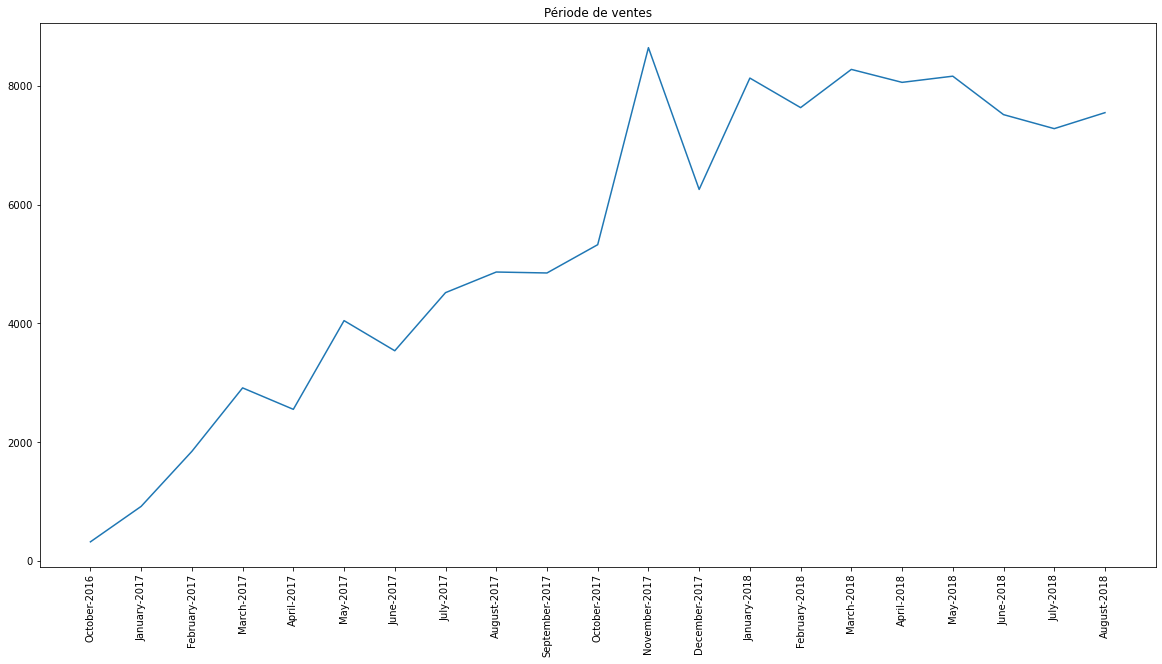

In [15]:
plt.figure(figsize=(20,10))
plt.plot(periode_ventes['Mois'],periode_ventes['Commande']);
plt.xticks(rotation=90);
plt.title('Période de ventes')

Nous voyons bien que la période où il y a eu le plus d'achats est en Novembre 2017.

# Définition de l'échantillon

On définit notre échantillon, pour pouvoir avoir les commandes des 18 premiers mois. L'idée est d'obtenir un échantillonage avec 1 mois entre chaque échantillon. Pour le calcul, nous prenons en référence qu'un mois est 30 jours, et que 18 mois représentent 540 jours.

In [16]:
def make_echantillon(df, n):
    periode_commandes = 540
    month = 30
    date_min = df['order_purchase_timestamp'].min()
    date_min = date_min + timedelta(days=month * (n - 1))
    date_max = date_min + timedelta(days=periode_commandes)
    echantillon_df = df[(df['order_purchase_timestamp'] > date_min) &
                   (df['order_purchase_timestamp'] < date_max)]

    print('Taille échantillon ', n, ' : ', echantillon_df.shape,
          '\nDonnées du ', echantillon_df['order_purchase_timestamp'].min(),
          ' au ', echantillon_df['order_purchase_timestamp'].max(), '\n')
    return echantillon_df.copy()

Notre premier échantillon de données T1 contient les commandes des 18 premiers mois.
Les échantillons suivants contiennent tous 18 mois de données avec un décalage d'1 mois entre chaque échantillon. On obtient 7 échantillons de données. 

In [17]:
P1 = make_echantillon(data, 1)
P2 = make_echantillon(data, 2)
P3 = make_echantillon(data, 3)
P4 = make_echantillon(data, 4)
P5 = make_echantillon(data, 5)
P6 = make_echantillon(data, 6)
P7 = make_echantillon(data, 7)

Taille échantillon  1  :  (74424, 9) 
Données du  2016-10-03 16:56:50  au  2018-03-27 09:38:25 

Taille échantillon  2  :  (81967, 9) 
Données du  2016-12-23 23:16:47  au  2018-04-26 09:11:49 

Taille échantillon  3  :  (90310, 9) 
Données du  2016-12-23 23:16:47  au  2018-05-26 09:35:59 

Taille échantillon  4  :  (97009, 9) 
Données du  2017-01-05 11:56:06  au  2018-06-25 09:35:30 

Taille échantillon  5  :  (102772, 9) 
Données du  2017-01-31 09:57:39  au  2018-07-25 09:40:59 

Taille échantillon  6  :  (109482, 9) 
Données du  2017-03-02 10:19:51  au  2018-08-24 09:41:37 

Taille échantillon  7  :  (106999, 9) 
Données du  2017-04-01 09:51:18  au  2018-08-29 15:00:37 



In [18]:
P1.head()

,customer_unique_id,order_purchase_timestamp,review_score,Durée_livraison,frequence_commande,Récence,Somme_depensee,date_achat_max,Mois_Année
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,4,8,1,469,146.87,2017-05-16 15:05:35,May-2017
1,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,1,18,2,293,413.67,2017-11-09 00:50:13,November-2017
2,9eae34bbd3a474ec5d07949ca7de67c0,2017-11-09 00:50:13,1,18,2,293,413.67,2017-11-09 00:50:13,November-2017
3,3c799d181c34d51f6d44bbbc563024db,2017-05-07 20:11:26,3,18,1,478,140.61,2017-05-07 20:11:26,May-2017
4,23397e992b09769faf5e66f9e171a241,2018-02-03 19:45:40,4,25,1,206,137.58,2018-02-03 19:45:40,February-2018


# Stabilité au cours du temps

Nous allons dans cette partie étudier la stabilité des clusters au cours du temps. A la suite à cette étude, nous réaliserons
une proposition de contrat de maintenance.
Pour étudier la stabilité des clusters au cours du temps, nous allons calculer l'écart entre un predict du modèle initial et le fit d'un nouveau modèle grâce à la fonction Ajusted_Rand_Score de la façon suivante: adjusted_rand_score (labels_true,labels_pred)

Nous établissons une Fonction qui entraine KMeans sur les données récentes et compare les labels obtenus avec ceux prédits par l'ancien modèle.

Il s’agit donc de simuler pour notre période d'échantillonage et d’afficher l’évolution de l’ARI. Si l’ARI passe à 0.8 ou moins, il est sûrement pertinent de reproposer un entraînement de modèle au client.

In [37]:
def fit_models(data, old_model):

    df = data.copy()
    X = df[['Récence', 'Somme_depensee', 'review_score', 'frequence_commande']]
    X_scaled = preprocessing.StandardScaler().fit_transform(X)
    new_model = cluster.KMeans(n_clusters=6, random_state=0)
    new_model.fit(X_scaled)
    labels_pred = new_model.labels_

    labels_true = old_model.predict(X_scaled)
    ARI = adjusted_rand_score(labels_true, labels_pred)

    return ARI

  Voici donc le modèle de base :

In [38]:
X = P1[['Récence', 'Somme_depensee', 'review_score', 'frequence_commande']]
X_scaled = preprocessing.StandardScaler().fit_transform(X)
model = cluster.KMeans(n_clusters=6, random_state=0)
model.fit(X_scaled)

KMeans(n_clusters=6, random_state=0)

In [39]:
ARI_P1 = fit_models(P1, model)

Le modèle sur le premier échantillon nous sert de base. On compare les prédictions du premier modèle avec le modèle réentrainé sur chaque échantillon.

In [40]:
#1 mois
ARI_P2 = fit_models(P2, model)
#2 mois
ARI_P3 = fit_models(P3, model)
#3 mois
ARI_P4 = fit_models(P4, model)
#4 mois
ARI_P5 = fit_models(P5, model)
#5 mois
ARI_P6 = fit_models(P6, model)
#6 mois
ARI_P7 = fit_models(P7, model)

On crée un nouveau dataframe avec nos données sur l'ARI pour estimer la comparaison : 

In [41]:
data_temps = pd.DataFrame({'Période échantillon': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7'],
                                'ARI': [ARI_P1,ARI_P2,ARI_P3,ARI_P4,ARI_P5,ARI_P6,ARI_P7]})

In [42]:
data_temps

,Période échantillon,ARI
0,P1,1.000000
1,P2,0.914133
2,P3,0.943755
3,P4,0.928823
4,P5,0.809604
5,P6,0.847187
6,P7,0.862861


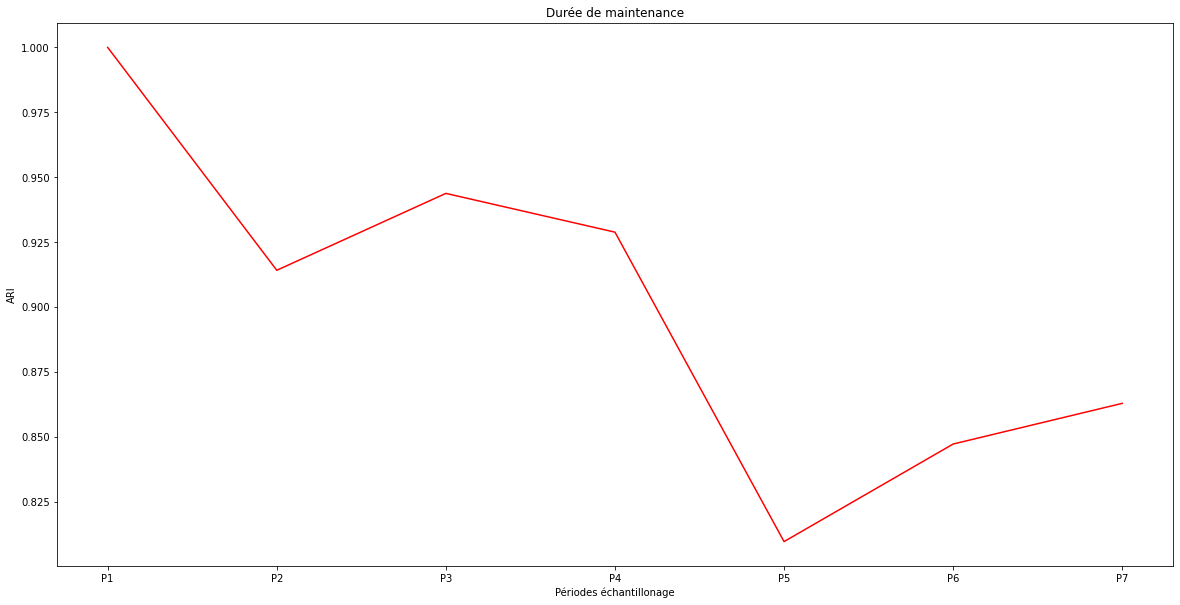

In [43]:
plt.figure(figsize=(20, 10))
plt.plot(data_temps['Période échantillon'], data_temps['ARI'], c='red')
plt.title('Durée de maintenance')
plt.xlabel('Périodes échantillonage')
plt.ylabel('ARI')
plt.show()

# Contrat de maintenance

Sur ce plot des scores ARI obtenus sur les itérations par période d'1 mois, on remarque une forte inflexion sur notre échantillon P5, soit 4 mois après notre premier échantillon T1. L'ARI passe en dessous à 0.8 à cette période là.
Il faudra donc prévoir la maintenance du programme de segmentation tous les 4 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.